## Data loading: 190 MB of image data

This is based on a sample of 10,000 rows of the [ImageNet](https://www.image-net.org/)
dataset. We add some blurry images and it will be our goal to remove them.

In [2]:
from utils import get_data, show_image, print_dataset_size
import lance

data = get_data()
uri = "image_data"
ds = lance.write_dataset(data, uri)
# ds = lance.dataset("image_data")

print_dataset_size(uri)

100%|██████████| 1000/1000 [00:13<00:00, 71.88it/s]


Total size of data: 192.91 MB


## Examining a random sample of data

,id,image
0,10205,
1,4185,
2,5874,
3,10682,
4,8684,
5,475,
6,7628,
7,4080,
8,10632,
9,849,

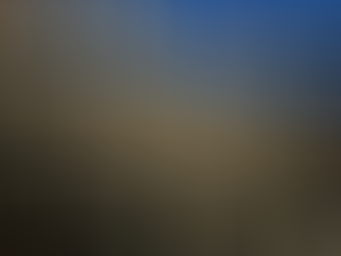
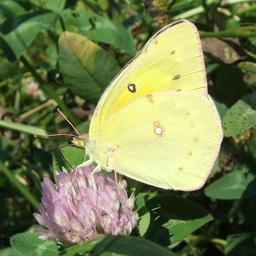
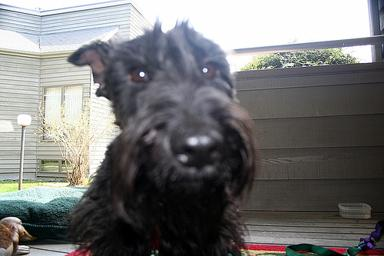
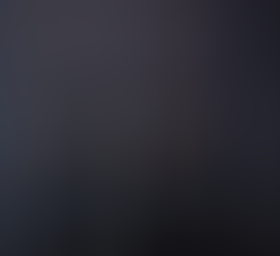
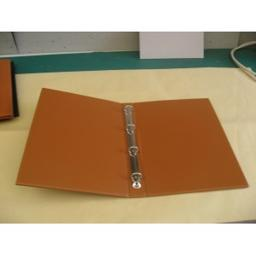
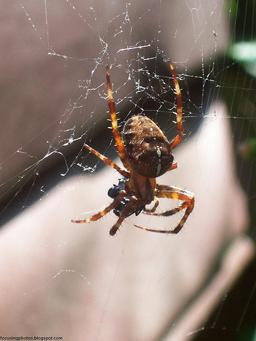
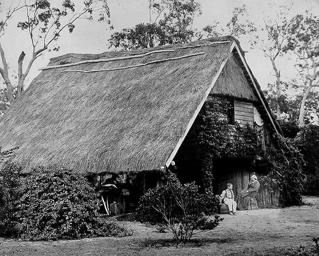
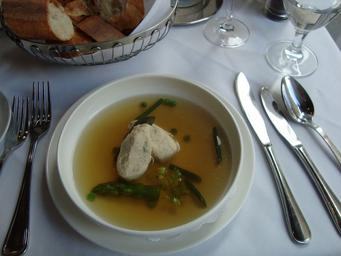
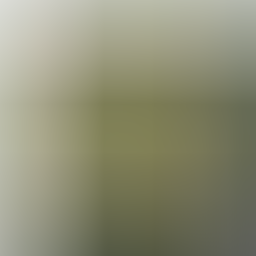
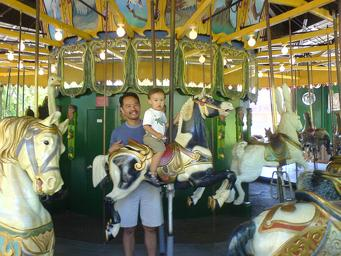

In [3]:
import random
from utils import display_df

random.seed(5)

num_rows = ds.count_rows()
sample_indices = [random.randint(0, num_rows) for _ in range(10)]
sample = ds.take(sample_indices)

display_df(sample)

## Can we use image embeddings to find blurry images?

In [4]:
from utils import get_image_embedding
# Using ResNet18
sample_embedding = get_image_embedding(sample['image'][0].as_py()).numpy()
sample_embedding

array([1.35420457e-01, 0.00000000e+00, 1.32512860e-02, 9.55288112e-01,
       1.30887493e-01, 0.00000000e+00, 4.14406247e-02, 1.28051090e+00,
       4.51225519e-01, 3.18845585e-02, 0.00000000e+00, 3.28922123e-01,
       3.24101234e-03, 3.29106930e-03, 5.32840669e-01, 3.19453955e-01,
       0.00000000e+00, 7.89550543e-01, 5.12737334e-01, 1.73924312e-01,
       7.16321349e-01, 3.45067173e-01, 2.24575587e-02, 0.00000000e+00,
       4.21104953e-03, 1.38635710e-01, 2.69226313e-01, 4.46788937e-01,
       2.86036342e-01, 0.00000000e+00, 1.29947722e-01, 4.68844205e-01,
       3.49374503e-01, 4.92883362e-02, 2.58452576e-02, 1.38624460e-02,
       5.01856983e-01, 6.33167252e-02, 1.53004038e+00, 2.23695636e-01,
       5.67382872e-02, 3.64168324e-02, 2.23212689e-01, 2.72571534e-01,
       4.50043738e-01, 1.96715623e-01, 1.28321022e-01, 2.56272554e-01,
       3.23766470e-03, 1.52376547e-01, 4.41183984e-01, 0.00000000e+00,
       2.76775379e-03, 0.00000000e+00, 4.80099954e-02, 1.18464470e-01,
      

## Add the new embedding column

In [5]:
import pyarrow as pa
import numpy as np

def add_embedding(batch):
    # Compute the embedding for each image
    vectors = [get_image_embedding(img.as_py()).numpy() for img in batch['image']]
    # Create a batch with the embedding as a column
    ndim = vectors[0].shape[0]
    values = pa.array(np.concatenate(vectors)).cast('float32')
    vectors = pa.FixedSizeListArray.from_arrays(values, ndim)
    return pa.record_batch([vectors], ["embedding"])

batch = next(iter(ds.to_batches(columns=['image'], batch_size=5)))
add_embedding(batch).to_pandas()

ExecNode(Projection): channel closed
ExecNode(Projection): channel closed


,embedding
0,"[0.45872626, 1.4526094, 0.54275453, 1.5168065,..."
1,"[0.503577, 0.74683833, 2.7698107, 0.4493271, 1..."
2,"[0.902283, 2.6531787, 1.5364902, 0.704672, 0.8..."
3,"[2.1611204, 0.91712135, 0.053006582, 0.6752639..."
4,"[0.5808478, 0.20932, 0.6222271, 0.5107773, 1.1..."


In [6]:
ds.add_columns(add_embedding, ['image'])



,id,image,embedding
0,0,,"[0.45872626, 1.4526094, 0.54275453, 1.5168065, 0.4720047, 0.121135175, 2.141615, 0.10894535, 0.2823503, 0.75509816, 2.7733083, 2.4852443, 1.8834778, 0.3994662, 0.83830255, 1.8326967, 0.7506734, 0.5598161, 0.123443924, 0.20005009, 0.56032705, 0.16361198, 0.4402906, 1.0226609, 3.0536938, 2.1451623, 0.25967786, 0.2766492, 1.3944559, 0.14824718, 1.5161028, 0.0012909953, 0.8132545, 0.25010234, 0.34292874, 0.03746854, 0.006567697, 0.071508646, 0.26794037, 0.07514253, 0.4235884, 2.6814165, 0.53604436, 0.27828276, 0.11591851, 1.2448272, 0.19507396, 0.48705316, 0.27887028, 0.2052185, 0.0, 1.3579499, 2.59193, 0.8718814, 0.75559586, 0.22091062, 1.1923977, 0.06208524, 0.9694238, 0.0, 1.1878895, 0.020847796, 0.7052765, 0.65900415, 2.9165494, 0.24870148, 0.64632004, 0.41048503, 0.5936688, 0.13192138, 0.53344464, 0.44510052, 2.4707685, 0.5191134, 0.32718205, 0.3179276, 0.0, 0.28633723, 0.56233346, 0.21705492, 0.49321684, 1.1680012, 1.2721622, 0.27439332, 0.2035691, 1.0334513, 1.4367065, 1.300351, 0.8348251, 0.053842556, 2.6259825, 1.8408036, 1.294809, 0.085695975, 1.4387729, 1.3274179, 2.269506, 0.726638, 0.072237164, 1.8006463, ...]"
1,1,,"[0.503577, 0.74683833, 2.7698107, 0.4493271, 1.6626582, 1.1074706, 0.19279672, 0.35270208, 2.353422, 1.4264528, 0.6906072, 0.32826924, 0.01764561, 0.0031025796, 0.42094845, 0.22832215, 1.0554899, 3.66971, 1.6827397, 0.103459634, 0.23778395, 0.22559164, 0.35814238, 1.4328699, 1.0908368, 0.38089463, 1.0980439, 0.37849337, 0.0034583358, 2.2724786, 0.7371429, 0.7562414, 1.0100261, 0.7493078, 1.3011904, 0.5900304, 2.699923, 1.5717835, 2.4355223, 0.91949636, 0.6539481, 3.695333, 0.17053294, 1.4179406, 1.0479712, 0.3885736, 0.5306856, 0.00048459703, 0.40208265, 0.03947012, 0.19837344, 0.06706586, 0.9412183, 0.006331885, 2.2631307, 1.1426922, 2.1225119, 0.32204154, 1.0892533, 1.5198637, 0.17550862, 0.14896782, 0.67735994, 0.31182528, 0.46319953, 2.8266876, 1.2482778, 0.35759306, 0.54703027, 2.8613923, 0.8051535, 1.4104117, 0.11522335, 0.17519775, 0.1343157, 0.06253677, 0.6219759, 0.058221098, 1.3060821, 0.9741763, 0.12522653, 0.0, 2.0924823, 0.18041357, 1.3338045, 0.6995213, 0.27775955, 2.9639437, 0.68672764, 0.27934483, 1.4232392, 1.4234519, 0.2814561, 0.16389222, 0.9915863, 1.567329, 0.68397856, 1.0466604, 0.97816527, 0.64989954, ...]"

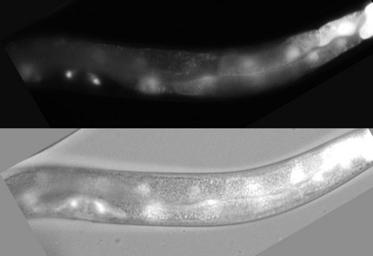
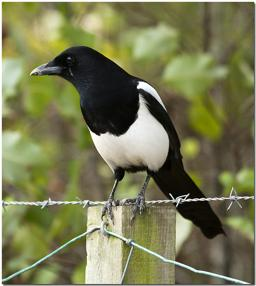

In [7]:
display_df(ds.head(2))

## Does our search work?

,id,image,embedding,_distance
0,10205,,"[0.13542046, 0.0, 0.013251286, 0.9552881, 0.1308875, 0.0, 0.041440625, 1.2805109, 0.45122552, 0.03188456, 0.0, 0.32892212, 0.0032410123, 0.0032910693, 0.53284067, 0.31945395, 0.0, 0.78955054, 0.51273733, 0.17392431, 0.71632135, 0.34506717, 0.022457559, 0.0, 0.0042110495, 0.13863571, 0.2692263, 0.44678894, 0.28603634, 0.0, 0.12994772, 0.4688442, 0.3493745, 0.049288336, 0.025845258, 0.013862446, 0.501857, 0.063316725, 1.5300404, 0.22369564, 0.056738287, 0.036416832, 0.22321269, 0.27257153, 0.45004374, 0.19671562, 0.12832102, 0.25627255, 0.0032376647, 0.15237655, 0.44118398, 0.0, 0.0027677538, 0.0, 0.048009995, 0.11846447, 0.7378196, 0.004224415, 0.13536853, 0.027076405, 0.2518565, 0.5146109, 0.052187383, 0.19970803, 0.38651457, 0.118274465, 0.0, 0.015803399, 0.0, 0.06553348, 0.0074920193, 1.008495, 0.009040333, 0.27772593, 0.0, 0.0, 0.01794336, 0.0063997554, 0.058815897, 0.011326679, 0.029758764, 0.42380273, 0.7683932, 0.082645856, 0.056389797, 0.0, 0.5177722, 0.8196238, 0.0096145775, 0.10030712, 0.0061417036, 0.2606527, 0.59067947, 0.0, 0.3368921, 0.007628391, 3.0039818, 0.0, 0.0004961089, 0.0044622626, ...]",0.000000
1,10284,,"[0.029736966, 0.005976936, 0.16345477, 1.5117898, 0.010790298, 0.0, 0.030513437, 0.39938253, 0.13346925, 0.04925288, 0.006196455, 0.18213823, 0.0, 0.0, 0.72740895, 0.5886723, 0.0, 1.3449473, 0.5336878, 0.06363113, 0.728303, 0.015237354, 0.0017690342, 0.00013988845, 0.13051547, 0.009858168, 0.0558908, 0.22541033, 0.11594149, 0.010684375, 0.01115951, 0.03470816, 0.09209736, 0.019387556, 0.029432919, 0.0, 0.21205786, 0.24339853, 1.3567506, 0.19686934, 0.0034167524, 0.022749092, 0.19448148, 0.6793055, 0.08578235, 0.38506886, 0.08765934, 0.037508555, 0.0, 0.10127494, 0.6482193, 0.0, 0.004522501, 0.0, 0.21851707, 0.11002815, 0.040336598, 0.0, 0.19802636, 0.0, 0.067719884, 0.8236247, 0.014745001, 0.14198677, 0.19301206, 0.07327188, 0.0, 0.044184595, 0.0, 0.0, 0.15855148, 1.1422594, 0.25408253, 0.31751585, 0.03865306, 0.03159449, 0.01739675, 0.0, 0.04179657, 0.0, 0.05241605, 0.5767382, 1.3905848, 0.0, 0.038879402, 0.008595117, 0.05361521, 1.2986344, 0.060555223, 0.09957186, 0.019499158, 0.26922745, 0.66550934, 0.0, 0.6519205, 0.0015269518, 2.722222, 0.0, 0.0013605392, 0.0, ...]",0.068552
2,10051,,"[0.0028611538, 0.0, 0.0043513603, 0.9962969, 0.035841484, 0.0029770331, 0.030656338, 0.2513771, 0.52722025, 0.21287163, 0.012218349, 0.06416895, 0.046707537, 0.0, 0.19583392, 0.047124192, 0.0, 0.5865398, 0.47108647, 0.0, 0.49017763, 0.04827277, 0.05888283, 0.004032028, 0.3625586, 0.006536031, 0.4143953, 0.18286, 0.18995433, 0.0015114071, 0.024270937, 0.4752637, 0.012289646, 0.014276951, 0.017094234, 0.0, 0.21343191, 0.25211334, 1.8976613, 0.109685704, 0.0, 0.0014278232, 0.09568217, 0.51318485, 0.4423589, 0.41190448, 0.036684033, 0.02559859, 0.038698003, 0.09755993, 0.5351878, 0.0, 0.0, 0.027311293, 0.27559346, 0.0, 0.19896613, 0.0, 0.228841, 0.01351875, 0.09386345, 0.42390227, 0.0, 0.1438171, 0.2337894, 0.008961849, 0.0, 0.01676386, 0.0, 0.0, 0.085432, 0.73369044, 0.14817405, 0.38239953, 0.0021655073, 0.0, 0.013261385, 0.0, 0.08922733, 0.01656463, 0.0, 0.5374771, 1.3192216, 0.0, 0.28209937, 0.0, 0.07471698, 1.3205949, 0.17910476, 0.15463662, 0.002547061, 0.18789272, 0.31879044, 0.0, 0.3963959, 0.0, 2.7252254, 0.0, 0.0, 0.0050497167, ...]",0.069602
3,10333,,"[0.08488969, 0.0, 0.025523353, 0.79487324, 0.020025749, 0.009014325, 0.100811206, 0.19781348, 0.4901685, 0.08109334, 0.0, 0.07430308, 0.018994704, 0.0, 0.5341771, 0.15794617, 0.0038333607, 1.2546265, 0.46844047, 0.21802197, 0.55292696, 0.06456666, 0.28133532, 0.0, 0.49876606, 0.019272, 0.0043166573, 0.30891725, 0.031424828, 0.0, 0.0039006004, 0.22538796, 0.02050593, 0.027078327, 0.012577417, 0.0, 0.2762912, 0.27734774, 2.3196855, 0.0490845, 0.0, 3.8635975e-05, 0.004541942, 0.271258, 0.7325158, 0.49254408, 0.004734139, 0.0, 0.009956012, 0.22757499, 0.55891305, 0.0, 0.0032165966, 0.004446153, 0.5313163, 0.03206301, 0.064559124, 
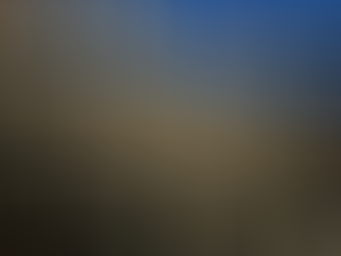
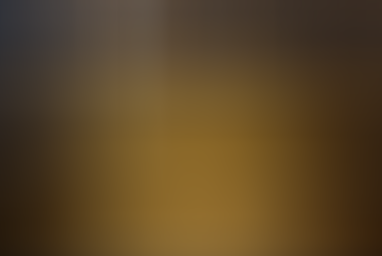
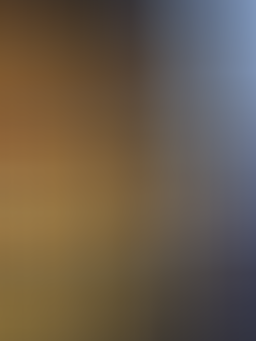
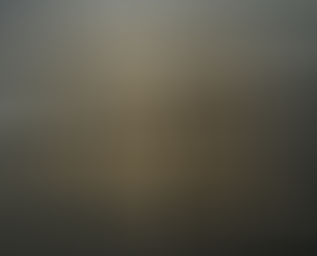
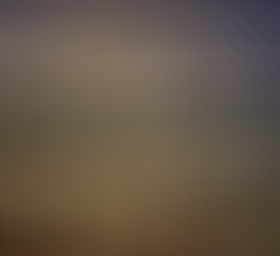

In [8]:
# KNN search
search_res = ds.to_table(
    columns=["id", "image"],
    nearest=dict(
        column="embedding",
        q=sample_embedding,
        k=5,
        metric="cosine",
    )
)

display_df(search_res)

In [9]:
# Decide a threshold for blurriness
distance_threshold = 0.15
search_res = ds.to_table(
    columns=["id"],
    nearest=dict(
        column="embedding",
        q=sample_embedding,
        k=5_000,
        metric="cosine",
    )
)
search_res = search_res.to_pandas().query(f"_distance < {distance_threshold}")

In [10]:
search_res

,id,embedding,_distance
0,10205,"[0.13542046, 0.0, 0.013251286, 0.9552881, 0.13...",0.000000
1,10284,"[0.029736966, 0.005976936, 0.16345477, 1.51178...",0.068552
2,10051,"[0.0028611538, 0.0, 0.0043513603, 0.9962969, 0...",0.069602
3,10333,"[0.08488969, 0.0, 0.025523353, 0.79487324, 0.0...",0.076480
4,10655,"[0.04594706, 0.0, 0.0, 0.21697286, 0.01056069,...",0.077685
...,...,...,...
384,10644,"[0.10869024, 0.0, 0.10616478, 0.65654427, 0.0,...",0.149194
385,10416,"[0.06015705, 0.0011648542, 0.17389888, 0.15351...",0.149201
386,10812,"[0.115207195, 0.0, 0.034606088, 1.0440402, 0.0...",0.149329
387,10828,"[0.0, 0.0, 0.0, 0.39525226, 0.0, 0.0, 0.030672...",0.149834


In [11]:
# Delete rows
ids_to_delete = [str(i) for i in search_res['id']]
ds.delete(f"id in ({','.join(ids_to_delete)})")

Adding new columns and deleting rows creates new versions.

In [12]:
ds.version

3

,id,image
0,0,
1,1,

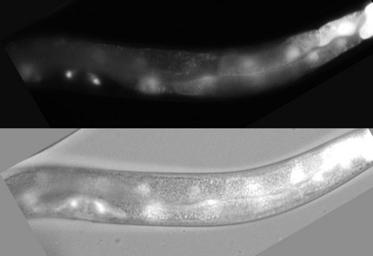
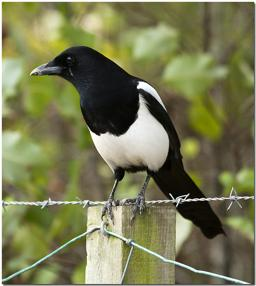

In [13]:
display_df(lance.dataset("image_data", version=1).head(2))

,id,image,embedding
0,0,,"[0.45872626, 1.4526094, 0.54275453, 1.5168065, 0.4720047, 0.121135175, 2.141615, 0.10894535, 0.2823503, 0.75509816, 2.7733083, 2.4852443, 1.8834778, 0.3994662, 0.83830255, 1.8326967, 0.7506734, 0.5598161, 0.123443924, 0.20005009, 0.56032705, 0.16361198, 0.4402906, 1.0226609, 3.0536938, 2.1451623, 0.25967786, 0.2766492, 1.3944559, 0.14824718, 1.5161028, 0.0012909953, 0.8132545, 0.25010234, 0.34292874, 0.03746854, 0.006567697, 0.071508646, 0.26794037, 0.07514253, 0.4235884, 2.6814165, 0.53604436, 0.27828276, 0.11591851, 1.2448272, 0.19507396, 0.48705316, 0.27887028, 0.2052185, 0.0, 1.3579499, 2.59193, 0.8718814, 0.75559586, 0.22091062, 1.1923977, 0.06208524, 0.9694238, 0.0, 1.1878895, 0.020847796, 0.7052765, 0.65900415, 2.9165494, 0.24870148, 0.64632004, 0.41048503, 0.5936688, 0.13192138, 0.53344464, 0.44510052, 2.4707685, 0.5191134, 0.32718205, 0.3179276, 0.0, 0.28633723, 0.56233346, 0.21705492, 0.49321684, 1.1680012, 1.2721622, 0.27439332, 0.2035691, 1.0334513, 1.4367065, 1.300351, 0.8348251, 0.053842556, 2.6259825, 1.8408036, 1.294809, 0.085695975, 1.4387729, 1.3274179, 2.269506, 0.726638, 0.072237164, 1.8006463, ...]"
1,1,,"[0.503577, 0.74683833, 2.7698107, 0.4493271, 1.6626582, 1.1074706, 0.19279672, 0.35270208, 2.353422, 1.4264528, 0.6906072, 0.32826924, 0.01764561, 0.0031025796, 0.42094845, 0.22832215, 1.0554899, 3.66971, 1.6827397, 0.103459634, 0.23778395, 0.22559164, 0.35814238, 1.4328699, 1.0908368, 0.38089463, 1.0980439, 0.37849337, 0.0034583358, 2.2724786, 0.7371429, 0.7562414, 1.0100261, 0.7493078, 1.3011904, 0.5900304, 2.699923, 1.5717835, 2.4355223, 0.91949636, 0.6539481, 3.695333, 0.17053294, 1.4179406, 1.0479712, 0.3885736, 0.5306856, 0.00048459703, 0.40208265, 0.03947012, 0.19837344, 0.06706586, 0.9412183, 0.006331885, 2.2631307, 1.1426922, 2.1225119, 0.32204154, 1.0892533, 1.5198637, 0.17550862, 0.14896782, 0.67735994, 0.31182528, 0.46319953, 2.8266876, 1.2482778, 0.35759306, 0.54703027, 2.8613923, 0.8051535, 1.4104117, 0.11522335, 0.17519775, 0.1343157, 0.06253677, 0.6219759, 0.058221098, 1.3060821, 0.9741763, 0.12522653, 0.0, 2.0924823, 0.18041357, 1.3338045, 0.6995213, 0.27775955, 2.9639437, 0.68672764, 0.27934483, 1.4232392, 1.4234519, 0.2814561, 0.16389222, 0.9915863, 1.567329, 0.68397856, 1.0466604, 0.97816527, 0.64989954, ...]"

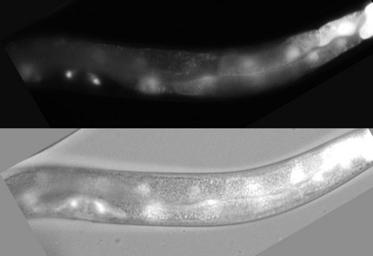
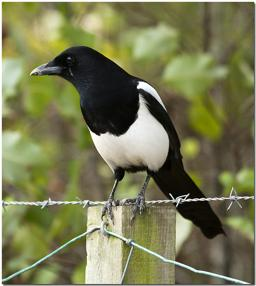

In [17]:
display_df(lance.dataset("image_data", version=2).head(2))

In [15]:
print(lance.dataset("image_data", version=1).count_rows())
print(lance.dataset("image_data", version=3).count_rows())

11000
10611


But the on disk size isn't a total replication of the original 200MB:

In [16]:
# Get the size of the dataset, note we have many versions but we haven't
# duplicated the dataset.
print_dataset_size(uri)

Total size of data: 214.40 MB
